# About Reinforcement Learning and Deep Q-Learning
> "Reinforcement learning is an area of machine learning that is focused on training agents to take certain actions at certain states from within an environment to maximize rewards. DQN (Deep Q-Net) is a reinforcement learning algorithm where a deep learning model is built to find the actions an agent can take at each state." [*Siwei Xu's tutorial
*](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998)

<a class="anchor" id="ToC"></a>
# Table of Contents
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Define useful classes](#define_useful_classes)
1. [Define helper-functions](#define_helper_functions)
1. [Create ConnectX environment](#create_connectx_environment)
1. [Configure hyper-parameters](#configure_hyper_parameters)
1. [Train the agent](#train_the_agent)
1. [Save weights](#save_weights)
1. [Create an agent](#create_an_agent)
1. [Evaluate the agent](#evaluate_the_agent)

<a class="anchor" id="install_libraries"></a>
# Install libraries
[Back to Table of Contents](#ToC)

In [1]:
!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

<a class="anchor" id="import_libraries"></a>
# Import libraries
[Back to Table of Contents](#ToC)

In [2]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make

<a class="anchor" id="define_useful_classes"></a>
# Define useful classes
NOTE: I use the neural network in [*Siwei Xu's tutorial
*](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998) with some proper modifications to adapt to the problem in ConnectX competition and be able to save trained and load pre-trained models.

[Back to Table of Contents](#ToC)

In [3]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)
    
    
class DeepModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(DeepModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='sigmoid', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

#     @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output


class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = DeepModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []} # The buffer
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))

#     @tf.function
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # Only start the training process when we have enough experiences in the buffer
            return 0

        # Randomly select n experience in the buffer, n is batch-size
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])

        # Prepare labels for training process
        states_next = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

    # Get an action by using epsilon-greedy
    def get_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state.board[c] == 0]))
        else:
            prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].numpy()
            for i in range(self.num_actions):
                if state.board[i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    # Method used to manage the buffer
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

    def save_weights(self, path):
        self.model.save_weights(path)

    def load_weights(self, path):
        ref_model = tf.keras.Sequential()

        ref_model.add(self.model.input_layer)
        for layer in self.model.hidden_layers:
            ref_model.add(layer)
        ref_model.add(self.model.output_layer)

        ref_model.load_weights(path)
    
    # Each state will consist of the board and the mark
    # in the observations
    def preprocess(self, state):
        result = state.board[:]
        result.append(state.mark)

        return result

<a class="anchor" id="define_helper_functions"></a>
# Define helper-functions
[Back to Table of Contents](#ToC)

In [4]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    while not done:
        # Using epsilon-greedy to get an action
        action = TrainNet.get_action(observations, epsilon)

        # Caching the information of current state
        prev_observations = observations

        # Take action
        observations, reward, done, _ = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        rewards += reward

        # Adding experience into buffer
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)

        # Train the training model by using experiences in buffer and the target model
        TrainNet.train(TargetNet)
        iter += 1
        if iter % copy_step == 0:
            # Update the weights of the target model when reaching enough "copy step"
            TargetNet.copy_weights(TrainNet)
    return rewards

<a class="anchor" id="create_connectx_environment"></a>
# Create ConnectX environment
[Back to Table of Contents](#ToC)

In [5]:
env = ConnectX()

<a class="anchor" id="configure_hyper_parameters"></a>
# Configure hyper-parameters
[Back to Table of Contents](#ToC)

In [6]:
gamma = 0.99
copy_step = 25
hidden_units = [100, 200, 200, 100]
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
epsilon = 0.99
decay = 0.99999
min_epsilon = 0.1
episodes = 100000

precision = 7

# log_dir = 'logs/'
# summary_writer = tf.summary.create_file_writer(log_dir)

<a class="anchor" id="train_the_agent"></a>
# Train the agent
[Back to Table of Contents](#ToC)

In [7]:
num_states = env.observation_space.n + 1
num_actions = env.action_space.n

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes) # Last 100 steps
all_epsilons = np.empty(episodes)

# Initialize models
TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)

In [8]:
pbar = tqdm(range(episodes))
for n in pbar:
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon

    pbar.set_postfix({
        'episode reward': total_reward,
        'avg (100 last) reward': avg_reward,
        'epsilon': epsilon
    })

#     with summary_writer.as_default():
#         tf.summary.scalar('episode reward', total_reward, step=n)
#         tf.summary.scalar('running avg reward (100)', avg_reward, step=n)
#         tf.summary.scalar('epsilon', epsilon, step=n)

In [9]:
# plt.plot(all_total_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')
# plt.show()

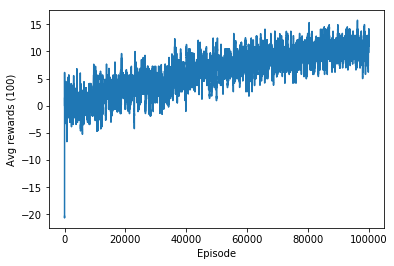

In [10]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

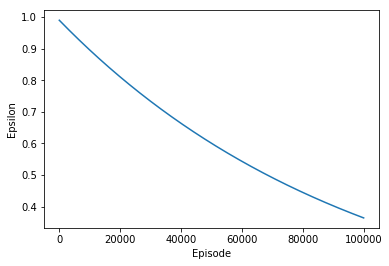

In [11]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

<a class="anchor" id="save_weights"></a>
# Save weights
[Back to Table of Contents](#ToC)

In [12]:
TrainNet.save_weights('./weights.h5')

<a class="anchor" id="create_an_agent"></a>
# Create an agent
[Back to Table of Contents](#ToC)

In [13]:
fc_layers = []

# Get all hidden layers' weights
for i in range(len(hidden_units)):
    fc_layers.extend([
        TrainNet.model.hidden_layers[i].weights[0].numpy().tolist(), # weights
        TrainNet.model.hidden_layers[i].weights[1].numpy().tolist() # bias
    ])

# Get output layer's weights
fc_layers.extend([
    TrainNet.model.output_layer.weights[0].numpy().tolist(), # weights
    TrainNet.model.output_layer.weights[1].numpy().tolist() # bias
])

# Convert all layers into usable form before integrating to final agent
fc_layers = list(map(
    lambda x: str(list(np.round(x, precision))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', ''),
    fc_layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)
# Write output layer
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation.board[:]
    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)

'''

# Calculate hidden layers
for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n' # Sigmoid function
# Calculate output layer
my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

In [14]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

<a class="anchor" id="evaluate_the_agent"></a>
# Evaluate the agent
[Back to Table of Contents](#ToC)

In [15]:
from submission import my_agent

In [16]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

My Agent vs. Random Agent: 0.9
My Agent vs. Negamax Agent: 0.0
Random Agent vs. My Agent: 0.2
Negamax Agent vs. My Agent: 1.0
